<a href="https://colab.research.google.com/github/o7s8r6/CVIVAAN/blob/main/pix2pix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

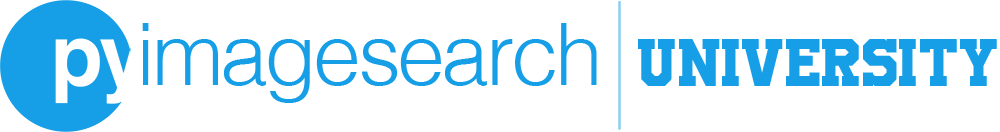

# Image Translation with Pix2Pix
### by [PyImageSearch.com](http://www.pyimagesearch.com)

## Welcome to **[PyImageSearch University](https://pyimg.co/university)** Jupyter Notebooks!

This notebook is associated with the [Image Translation with Pix2Pix](https://pyimg.co/ma1qi) blog post published on 2022-07-27.

Only the code for the blog post is here. Most codeblocks have a 1:1 relationship with what you find in the blog post with two exceptions: (1) Python classes are not separate files as they are typically organized with PyImageSearch projects, and (2) Command Line Argument parsing is replaced with an `args` dictionary that you can manipulate as needed.

We recommend that you execute (press ▶️) the code block-by-block, as-is, before adjusting parameters and `args` inputs. Once you've verified that the code is working, you are welcome to hack with it and learn from manipulating inputs, settings, and parameters. For more information on using Jupyter and Colab, please refer to these resources:

*   [Jupyter Notebook User Interface](https://jupyter-notebook.readthedocs.io/en/stable/notebook.html#notebook-user-interface)
*   [Overview of Google Colaboratory Features](https://colab.research.google.com/notebooks/basic_features_overview.ipynb)

As a reminder, these PyImageSearch University Jupyter Notebooks are not for sharing; please refer to the **Copyright** directly below and **Code License Agreement** in the last cell of this notebook. 

Happy hacking!

*PyImageSearch Team*

<hr>

***Copyright:*** *The contents of this Jupyter Notebook, unless otherwise indicated, are Copyright 2022 OptiReto, LLC and PyImageSearch.com. All rights reserved. Content like this is made possible by the time invested by the authors. If you received this Jupyter Notebook and did not purchase it, please consider making future content possible by joining PyImageSearch University at https://pyimg.co/university today.*

### Download the code zip file

In [ ]:
!wget https://pyimagesearch-code-downloads.s3.us-west-2.amazonaws.com/pix2pix/pix2pix.zip
!unzip -qq pix2pix.zip
%cd pix2pix

## Blog Post Code

### Import Packages

In [ ]:
# import tensorflow and fix the random seed for better reproducibility
import tensorflow as tf
tf.random.set_seed(42)

# import the necessary packages
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import get_file
from tensorflow.keras import Model
from tensorflow.keras import Input
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
import tensorflow as tf
import pathlib
import os

### Configuration

In [ ]:
class Config(object):
	# name of the dataset we will be using 
	DATASET = "cityscapes"

	# build the dataset URL
	DATASET_URL  = f"http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{DATASET}.tar.gz"

	# define the batch size
	TRAIN_BATCH_SIZE = 32
	INFER_BATCH_SIZE = 8

	# dataset specs
	IMAGE_WIDTH = 256
	IMAGE_HEIGHT = 256
	IMAGE_CHANNELS = 3

	# training specs
	LEARNING_RATE = 2e-4
	EPOCHS = 15
	STEPS_PER_EPOCH = 2

	# path to the base output directory
	BASE_OUTPUT_PATH = "outputs"
	TEMP_BASE_OUTPUT_PATH = "temp_outputs"

	# path to the pix2pix generator
	GENERATOR_MODEL = os.path.join(
		BASE_OUTPUT_PATH, "models", "generator"
	)
	TEMP_GENERATOR_MODEL = os.path.join(
		TEMP_BASE_OUTPUT_PATH, "models", "generator"
	)

	# path to the inferred images and to the grid image
	BASE_IMAGES_PATH = os.path.join(BASE_OUTPUT_PATH, "images")
	GRID_IMAGE_PATH = os.path.join(BASE_IMAGES_PATH, "grid.png")
	TEMP_BASE_IMAGES_PATH = os.path.join(TEMP_BASE_OUTPUT_PATH, "images")
	TEMP_GRID_IMAGE_PATH = os.path.join(TEMP_BASE_IMAGES_PATH, "grid.png")

config = Config()

### Download the `cityscape` dataset

In [ ]:
# download the cityscape training dataset 
print("[INFO] downloading the dataset...")
pathToZip = get_file(
	fname=f"{config.DATASET}.tar.gz",
	origin=config.DATASET_URL ,
	extract=True
)
pathToZip  = pathlib.Path(pathToZip)
path = pathToZip.parent/config.DATASET

### Dataset Utilities

In [ ]:
# define the module level autotune
AUTO = tf.data.AUTOTUNE

def load_image(imageFile):
	# read and decode an image file from the path
	image = tf.io.read_file(imageFile)
	image = tf.io.decode_jpeg(image, channels=3)

	# calculate the midpoint of the width and split the
	# combined image into input mask and real image 
	width = tf.shape(image)[1]
	splitPoint = width // 2
	inputMask = image[:, splitPoint:, :]
	realImage = image[:, :splitPoint, :]

	# convert both images to float32 tensors and
	# convert pixels to the range of -1 and 1
	inputMask = tf.cast(inputMask, tf.float32)/127.5 - 1
	realImage = tf.cast(realImage, tf.float32)/127.5 - 1

	# return the input mask and real label image
	return (inputMask, realImage)

In [ ]:
def random_jitter(inputMask, realImage, height, width):
	# upscale the images for cropping purposes
	inputMask = tf.image.resize(inputMask, [height, width],
		method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
	realImage = tf.image.resize(realImage, [height, width],
		method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

	# return the input mask and real label image
	return (inputMask, realImage)

In [ ]:
class ReadTrainExample(object):
	def __init__(self, imageHeight, imageWidth):
		self.imageHeight = imageHeight
		self.imageWidth = imageWidth
	
	def __call__(self, imageFile):
		# read the file path and unpack the image pair
		inputMask, realImage = load_image(imageFile)

		# perform data augmentation
		(inputMask, realImage) = random_jitter(inputMask, realImage,
			self.imageHeight+30, self.imageWidth+30)

		# reshape the input mask and real label image
		inputMask = tf.image.resize(inputMask,
			[self.imageHeight, self.imageWidth])
		realImage = tf.image.resize(realImage,
			[self.imageHeight, self.imageWidth])

		# return the input mask and real label image
		return (inputMask, realImage)

In [ ]:
class ReadTestExample(object):
	def __init__(self, imageHeight, imageWidth):
		self.imageHeight = imageHeight
		self.imageWidth = imageWidth

	def __call__(self, imageFile):
		# read the file path and unpack the image pair
		(inputMask, realImage) = load_image(imageFile)

		# reshape the input mask and real label image
		inputMask = tf.image.resize(inputMask,
			[self.imageHeight, self.imageWidth])
		realImage = tf.image.resize(realImage,
			[self.imageHeight, self.imageWidth])

		# return the input mask and real label image
		return (inputMask, realImage)

In [ ]:
def load_dataset(path, batchSize, height, width, train=False):
	# check if this is the training dataset
	if train:
		# read the training examples
		dataset = tf.data.Dataset.list_files(str(path/"train/*.jpg"))
		dataset = dataset.map(ReadTrainExample(height, width),
			num_parallel_calls=AUTO)
	# otherwise, we are working with the test dataset
	else:
		# read the test examples
		dataset = tf.data.Dataset.list_files(str(path/"val/*.jpg"))
		dataset = dataset.map(ReadTestExample(height, width),
			num_parallel_calls=AUTO)

	# shuffle, batch, repeat and prefetch the dataset
	dataset = (dataset
		.shuffle(batchSize * 2)
		.batch(batchSize)
		.repeat()
		.prefetch(AUTO)
	)

	# return the dataset
	return dataset

### Load the dataset into `tf.data` format

In [ ]:
# build the training dataset
print("[INFO] building the train dataset...")
trainDs = load_dataset(path=path, train=True,
	batchSize=config.TRAIN_BATCH_SIZE, height=config.IMAGE_HEIGHT,
	width=config.IMAGE_WIDTH)

# build the test dataset
print("[INFO] building the test dataset...")
testDs = load_dataset(path=path, train=False,
	batchSize=config.INFER_BATCH_SIZE, height=config.IMAGE_HEIGHT,
	width=config.IMAGE_WIDTH)

### Model utilities

In [ ]:
class Pix2Pix(object):
	def __init__(self, imageHeight, imageWidth):
		# initialize the image height and width
		self.imageHeight = imageHeight
		self.imageWidth = imageWidth

	def generator(self):
		# initialize the input layer
		inputs = Input([self.imageHeight, self.imageWidth, 3])
  
		# down Layer 1 (d1) => final layer 1 (f1)
		d1 = Conv2D(32, (3, 3), activation="relu", padding="same")(
			inputs)
		d1 = Dropout(0.1)(d1)
		f1 = MaxPool2D((2, 2))(d1)

		# down Layer 2 (l2) => final layer 2 (f2)
		d2 = Conv2D(64, (3, 3), activation="relu", padding="same")(f1)
		f2 = MaxPool2D((2, 2))(d2)

		#  down Layer 3 (l3) => final layer 3 (f3)
		d3 = Conv2D(96, (3, 3), activation="relu", padding="same")(f2)
		f3 = MaxPool2D((2, 2))(d3)

		# down Layer 4 (l3) => final layer 4 (f4)
		d4 = Conv2D(96, (3, 3), activation="relu", padding="same")(f3)
		f4 = MaxPool2D((2, 2))(d4)

		# u-bend of the u-bet
		b5 = Conv2D(96, (3, 3), activation="relu", padding="same")(f4)
		b5 = Dropout(0.3)(b5)
		b5 = Conv2D(256, (3, 3), activation="relu", padding="same")(b5)

		# upsample Layer 6 (u6)
		u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2),
			padding="same")(b5)
		u6 = concatenate([u6, d4])
		u6 = Conv2D(128, (3, 3), activation="relu", padding="same")(
			u6)

		# upsample Layer 7 (u7)
		u7 = Conv2DTranspose(96, (2, 2), strides=(2, 2),
			padding="same")(u6)
		u7 = concatenate([u7, d3])
		u7 = Conv2D(128, (3, 3), activation="relu", padding="same")(
			u7)

		# upsample Layer 8 (u8)
		u8 = Conv2DTranspose(64, (2, 2), strides=(2, 2),
			padding="same")(u7)
		u8 = concatenate([u8, d2])
		u8 = Conv2D(128, (3, 3), activation="relu", padding="same")(u8)

		# upsample Layer 9 (u9)
		u9 = Conv2DTranspose(32, (2, 2), strides=(2, 2),
			padding="same")(u8)
		u9 = concatenate([u9, d1])
		u9 = Dropout(0.1)(u9)
		u9 = Conv2D(128, (3, 3), activation="relu", padding="same")(u9)

		# final conv2D layer
		outputLayer = Conv2D(3, (1, 1), activation="tanh")(u9)
	
		# create the generator model
		generator = Model(inputs, outputLayer)

		# return the generator
		return generator

	def discriminator(self):
		# initialize input layer according to PatchGAN
		inputMask = Input(shape=[self.imageHeight, self.imageWidth, 3], 
			name="input_image"
		)
		targetImage = Input(
			shape=[self.imageHeight, self.imageWidth, 3], 
			name="target_image"
		)
  
		# concatenate the inputs
		x = concatenate([inputMask, targetImage])  

		# add four conv2D convolution layers
		x = Conv2D(64, 4, strides=2, padding="same")(x)  
		x = LeakyReLU()(x)
		x = Conv2D(128, 4, strides=2, padding="same")(x)
		x = LeakyReLU()(x)  
		x = Conv2D(256, 4, strides=2, padding="same")(x)
		x = LeakyReLU()(x)   
		x = Conv2D(512, 4, strides=1, padding="same")(x)  

		# add a batch-normalization layer => LeakyReLU => zeropad
		x = BatchNormalization()(x)
		x = LeakyReLU()(x)

		# final conv layer
		last = Conv2D(1, 3, strides=1)(x) 
  
		# create the discriminator model
		discriminator = Model(inputs=[inputMask, targetImage],
			outputs=last)

		# return the discriminator
		return discriminator

### Build the Pix2Pix GAN model

In [ ]:
# initialize the generator and discriminator network
print("[INFO] initializing the generator and discriminator...")
pix2pixObject = Pix2Pix(imageHeight=config.IMAGE_HEIGHT,
	imageWidth=config.IMAGE_WIDTH)
generator = pix2pixObject.generator()
discriminator = pix2pixObject.discriminator()

### Model training utilities

In [ ]:
class Pix2PixTraining(Model):
	def __init__(self, generator, discriminator):
		super().__init__()
		# initialize the generator, discriminator
		self.generator = generator
		self.discriminator = discriminator

	def compile(self, gOptimizer, dOptimizer, bceLoss, maeLoss):
		super().compile()
		# initialize the optimizers for the generator 
		# and discriminator
		self.gOptimizer = gOptimizer
		self.dOptimizer = dOptimizer
		
		# initialize the loss functions
		self.bceLoss = bceLoss
		self.maeLoss = maeLoss
	
	def train_step(self, inputs):
		# grab the input mask and corresponding real images
		(inputMask, realImages) = inputs

		# initialize gradient tapes for both generator and discriminator
		with tf.GradientTape() as genTape, tf.GradientTape() as discTape:
			# generate fake images
			fakeImages = self.generator(inputMask, training=True)

			# discriminator output for real images and fake images
			discRealOutput = self.discriminator(
				[inputMask, realImages], training=True)
			discFakeOutput = self.discriminator(
				[inputMask, fakeImages], training=True)

			# compute the adversarial loss for the generator
			misleadingImageLabels = tf.ones_like(discFakeOutput) 
			ganLoss = self.bceLoss(misleadingImageLabels, discFakeOutput)

			# compute the mean absolute error between the fake and the
			# real images
			l1Loss = self.maeLoss(realImages, fakeImages)

			# compute the total generator loss
			totalGenLoss = ganLoss + (10 * l1Loss)

			# discriminator loss for real and fake images
			realImageLabels = tf.ones_like(discRealOutput)
			realDiscLoss = self.bceLoss(realImageLabels, discRealOutput)
			fakeImageLabels = tf.zeros_like(discFakeOutput)
			generatedLoss = self.bceLoss(fakeImageLabels, discFakeOutput)

			# compute the total discriminator loss
			totalDiscLoss = realDiscLoss + generatedLoss

		# calculate the generator and discriminator gradients
		generatorGradients = genTape.gradient(totalGenLoss, 
			self.generator.trainable_variables
		)
		discriminatorGradients = discTape.gradient(totalDiscLoss, 
			self.discriminator.trainable_variables
		)

		# apply the gradients to optimize the generator and discriminator
		self.gOptimizer.apply_gradients(zip(generatorGradients,
			self.generator.trainable_variables)
		)
		self.dOptimizer.apply_gradients(zip(discriminatorGradients,
			self.discriminator.trainable_variables)
		)

		# return the generator and discriminator losses
		return {"dLoss": totalDiscLoss, "gLoss": totalGenLoss}

### Building the trainer

In [ ]:
# build the pix2pix training model and compile it
pix2pixModel = Pix2PixTraining(
	generator=generator,
	discriminator=discriminator)
pix2pixModel.compile(
	dOptimizer=Adam(learning_rate=config.LEARNING_RATE),
	gOptimizer=Adam(learning_rate=config.LEARNING_RATE),
	bceLoss=BinaryCrossentropy(from_logits=True),
	maeLoss=MeanAbsoluteError(),
)

### Monitor Callback

In [ ]:
# check whether output model directory exists
# if it doesn't, then create it
if not os.path.exists(config.TEMP_BASE_OUTPUT_PATH):
	os.makedirs(config.TEMP_BASE_OUTPUT_PATH)

# check whether output image directory exists, if it doesn't, then
# create it
if not os.path.exists(config.TEMP_BASE_IMAGES_PATH):
	os.makedirs(config.TEMP_BASE_IMAGES_PATH)

In [ ]:
def get_train_monitor(testDs, imagePath, batchSize, epochInterval):
	# grab the input mask and the real image from the testing dataset
	(tInputMask, tRealImage) = next(iter(testDs))

	class TrainMonitor(Callback):
		def __init__(self, epochInterval=None):
			self.epochInterval = epochInterval

		def on_epoch_end(self, epoch, logs=None):
			if self.epochInterval and epoch % self.epochInterval == 0:
				# get the pix2pix prediction
				tPix2pixGenPred = self.model.generator.predict(tInputMask)

				(fig, axes) = subplots(nrows=batchSize, ncols=3,
					figsize=(5, 20))

				# plot the predicted images 
				for (ax, inp, pred, tgt) in zip(axes, tInputMask,
					tPix2pixGenPred, tRealImage):
					# plot the input mask image
					ax[0].imshow(array_to_img(inp))
					ax[0].set_title("Input Image")

					# plot the predicted Pix2Pix image
					ax[1].imshow(array_to_img(pred))
					ax[1].set_title("Pix2Pix Prediction")

					# plot the ground truth
					ax[2].imshow(array_to_img(tgt))
					ax[2].set_title("Target Label")

				plt.show()
	
	# instantiate a train monitor callback
	trainMonitor = TrainMonitor(epochInterval=epochInterval)

	# return the train monitor
	return trainMonitor

### Training the model

In the colab notebook, we train the model for a smaller epochs (due to time constraints) to show how the model trains. In the blog post we have trained the GAN for **150** epochs which gives us good results. We have provided our trained model for inference. 

If you want to infer on the trained model, jump straight over to the inference section 🤩.

In [ ]:
# train the pix2pix model
print("[INFO] training the pix2pix model...")
callbacks = [get_train_monitor(testDs, epochInterval=10,
	imagePath=config.TEMP_BASE_IMAGES_PATH,
	batchSize=config.INFER_BATCH_SIZE)]

pix2pixModel.fit(trainDs, epochs=config.EPOCHS, callbacks=callbacks,
	steps_per_epoch=config.STEPS_PER_EPOCH)

# set the path for the generator
genPath = config.TEMP_GENERATOR_MODEL

# save the pix2pix generator
print(f"[INFO] saving pix2pix generator to {genPath}...")
pix2pixModel.generator.save(genPath)

### Inference

In [ ]:
# get the first batch of testing images
(inputMask, realImage) = next(iter(testDs))

# set the path for the generator
genPath = config.GENERATOR_MODEL

# load the trained pix2pix generator
print("[INFO] loading the trained pix2pix generator...")
pix2pixGen = load_model(genPath, compile=False)
	
# predict using pix2pix generator
print("[INFO] making predictions with the generator...")
pix2pixGenPred = pix2pixGen.predict(inputMask)

# plot the respective predictions
print("[INFO] saving the predictions...")
(fig, axes) = subplots(nrows=config.INFER_BATCH_SIZE, ncols=3,
	figsize=(10, 30))

# plot the predicted images 
for (ax, inp, pred, tgt) in zip(axes, inputMask, pix2pixGenPred,
	realImage):
	# plot the input mask image
	ax[0].imshow(array_to_img(inp))
	ax[0].set_title("Input Image")

	# plot the predicted Pix2Pix image
	ax[1].imshow(array_to_img(pred))
	ax[1].set_title("Pix2Pix Prediction")

	# plot the ground truth
	ax[2].imshow(array_to_img(tgt))
	ax[2].set_title("Target Label")

# check whether output image directory exists, if it doesn't, then
# create it
if not os.path.exists(config.BASE_IMAGES_PATH):
	os.makedirs(config.BASE_IMAGES_PATH)

# serialize the results to disk
print("[INFO] saving the pix2pix predictions to disk...")
fig.savefig(config.GRID_IMAGE_PATH)

For a detailed walkthrough of the concepts and code, be sure to refer to the full tutorial, [*Image Translation with Pix2Pix*](https://pyimg.co/ma1qi) published on 2022-07-27

# Code License Agreement
```
Copyright (c) 2022 PyImageSearch.com

SIMPLE VERSION
Feel free to use this code for your own projects, whether they are
purely educational, for fun, or for profit. THE EXCEPTION BEING if
you are developing a course, book, or other educational product.
Under *NO CIRCUMSTANCE* may you use this code for your own paid
educational or self-promotional ventures without written consent
from OptiReto, LLC and PyImageSearch.com.

LONGER, FORMAL VERSION
Permission is hereby granted, free of charge, to any person obtaining
a copy of this software and associated documentation files
(the "Software"), to deal in the Software without restriction,
including without limitation the rights to use, copy, modify, merge,
publish, distribute, sublicense, and/or sell copies of the Software,
and to permit persons to whom the Software is furnished to do so,
subject to the following conditions:
The above copyright notice and this permission notice shall be
included in all copies or substantial portions of the Software.
Notwithstanding the foregoing, you may not use, copy, modify, merge,
publish, distribute, sublicense, create a derivative work, and/or
sell copies of the Software in any work that is designed, intended,
or marketed for pedagogical or instructional purposes related to
programming, coding, application development, or information
technology. Permission for such use, copying, modification, and
merger, publication, distribution, sub-licensing, creation of
derivative works, or sale is expressly withheld.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND,
EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES
OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND
NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS
BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN
ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
```